In [ ]:
from google.colab import drive
drive.mount('/gdrive')

%cd /gdrive/My\ Drive/Colab\ Notebooks/esun_tbrain/thesis_reading

In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install nlpaug
!pip install fairseq>=0.9.0 sacremoses>=0.0.43 fastBPE>=0.1.0
!apt-get install cmake build-essential pkg-config libgoogle-perftools-dev

from https://towardsdatascience.com/transformers-for-multilabel-classification-71a1a0daf5e1

In [ ]:
import pickle
from ast import literal_eval
import gc
import re
import os, sys

import pandas as pd
import numpy as np

from tqdm import trange
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score

import tensorflow as tf
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau

from keras.preprocessing.sequence import pad_sequences
from transformers import *

import nlpaug.augmenter.word as naw

import matplotlib.pyplot as plt

In [ ]:
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

max_length = 512

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 16  # 16

# Number of training epochs (authors recommend between 2 and 4)
epochs = 12

path_model = 'scibert_uncased_2.model'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
# torch.cuda.get_device_name(0)

In [ ]:
df_train = pd.read_csv('data/trainset.csv')
df_train['text'] = df_train.Title + ' [SEP] ' + df_train.Abstract.replace('\$\$\$', ' [SEP] ', regex=True)

df_train

,Title,Abstract,Classifications,text
0,"Distinctiveness, complexity, and repeatability...",This paper proposes three measures to quantify...,ENGINEERING,"Distinctiveness, complexity, and repeatability..."
1,An Adaptable Fast Matrix Multiplication Algori...,In this paper we present an adaptable fast mat...,EMPIRICAL,An Adaptable Fast Matrix Multiplication Algori...
2,Trimming the Multipath for Efficient Dynamic R...,Multipath routing is a trivial way to exploit ...,THEORETICAL ENGINEERING,Trimming the Multipath for Efficient Dynamic R...
3,Learning Word Embeddings from Speech,"In this paper, we propose a novel deep neural ...",ENGINEERING EMPIRICAL,Learning Word Embeddings from Speech [SEP] In ...
4,A Unified Model for Near and Remote Sensing,We propose a novel convolutional neural networ...,THEORETICAL ENGINEERING,A Unified Model for Near and Remote Sensing [S...
...,...,...,...,...
6995,Small vulnerable sets determine large network ...,The understanding of cascading failures in com...,THEORETICAL EMPIRICAL,Small vulnerable sets determine large network ...
6996,Emergence of Human-comparable Balancing Behavi...,This paper presents a hierarchical framework b...,ENGINEERING,Emergence of Human-comparable Balancing Behavi...
6997,Neural Paraphrase Generation with Stacked Resi...,"In this paper, we propose a novel neural appro...",EMPIRICAL,Neural Paraphrase Generation with Stacked Resi...
6998,Efficient Twitter Sentiment Classification usi...,As microblogging services like Twitter are bec...,EMPIRICAL,Efficient Twitter Sentiment Classification usi...


In [ ]:
df_train['Abstract'][0]

'This paper proposes three measures to quantify the characteristics of online signature templates in terms of distinctiveness, complexity and repeatability.$$$A distinctiveness measure of a signature template is computed from a set of enrolled signature samples and a statistical assumption about random signatures.$$$Secondly, a complexity measure of the template is derived from a set of enrolled signature samples.$$$Finally, given a signature template, a measure to quantify the repeatability of the online signature is derived from a validation set of samples.$$$These three measures can then be used as an indicator for the performance of the system in rejecting random forgery samples and skilled forgery samples and the performance of users in providing accepted genuine samples, respectively.$$$The effectiveness of these three measures and their applications are demonstrated through experiments performed on three online signature datasets and one keystroke dynamics dataset using differen

train data text len distribution


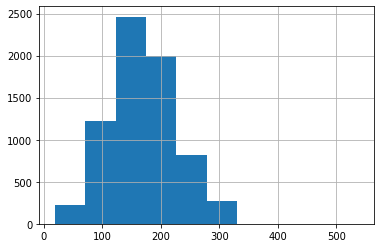

In [ ]:
print('train data text len distribution')
df_train.text.str.split(' ').map(len).hist()

In [ ]:
df_test = pd.read_csv('data/testset.csv')
df_test['text'] = df_test.Title + ' [SEP] ' + df_test.Abstract.replace('\$\$\$', '[SEP]', regex=True)

df_test

,Id,Title,Abstract,text
0,1,Efficient Visual Coding: From Retina To V2,The human visual system has a hierarchical str...,Efficient Visual Coding: From Retina To V2 [SE...
1,2,PolyMorph: Increasing P300 Spelling Efficiency...,P300 is an electric signal emitted by brain ab...,PolyMorph: Increasing P300 Spelling Efficiency...
2,3,"Cooperative Cognitive Networks: Optimal, Distr...",This paper considers the cooperation between a...,"Cooperative Cognitive Networks: Optimal, Distr..."
3,4,Indoor occupancy estimation from carbon dioxid...,This paper presents an indoor occupancy estima...,Indoor occupancy estimation from carbon dioxid...
4,5,Lower Bound for General Circuits Computing Cli...,We prove an exponential lower bound for genera...,Lower Bound for General Circuits Computing Cli...
...,...,...,...,...
39995,39996,"Structure and Recognition of 3,4-leaf Powers o...",A graph is a $k$-leaf power of a tree $T$ if i...,"Structure and Recognition of 3,4-leaf Powers o..."
39996,39997,Extended Report: The Implicit Calculus,Generic programming (GP) is an increasingly im...,Extended Report: The Implicit Calculus [SEP] G...
39997,39998,ConGUSTo: (HT)Condor Graphical Unified Supervi...,HTCondor is a distributed job scheduler develo...,ConGUSTo: (HT)Condor Graphical Unified Supervi...
39998,39999,Protein Folding in the Hexagonal Prism Lattice...,Predicting protein secondary structure using l...,Protein Folding in the Hexagonal Prism Lattice...


In [ ]:
import spacy
from collections import Counter

idx = 6

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
doc = nlp(df_train['text'][idx])
words = [token.lemma_ for token in doc if token.is_stop != True and token.is_punct != True]
word_freq = Counter(words)
{k:word_freq[k] for k in word_freq if word_freq[k] > 1}

{'3d': 3,
 'SEP': 9,
 'annotated': 2,
 'automate': 2,
 'case': 2,
 'end': 2,
 'image': 2,
 'learn': 2,
 'method': 2,
 'network': 5,
 'propose': 2,
 'segment': 2,
 'segmentation': 2,
 'set': 2,
 'setup': 2,
 'sparsely': 2,
 'train': 3,
 'training': 2,
 'use': 2,
 'volumetric': 3}

In [ ]:
'''
Theoretical paper: A theoretical paper describes a theory or algorithm or provides a mathematical proof for some hypothesis.
Engineering paper: An engineering paper describes an implementation of an algorithm, 
or part or all of a computer system or application. Engineering papers are now frequently required to include descriptions of system evaluation.
Empirical paper: An empirical paper describes an experiment designed to test some hypothesis (more than one).
'''

'\nTheoretical paper: A theoretical paper describes a theory or algorithm or provides a mathematical proof for some hypothesis.\nEngineering paper: An engineering paper describes an implementation of an algorithm, \nor part or all of a computer system or application. Engineering papers are now frequently required to include descriptions of system evaluation.\nEmpirical paper: An empirical paper describes an experiment designed to test some hypothesis (more than one).\n'

In [ ]:
from transformers import MarianMTModel, MarianTokenizer

target_model_name = 'Helsinki-NLP/opus-mt-en-ROMANCE'
target_tokenizer = MarianTokenizer.from_pretrained(target_model_name)
target_model = MarianMTModel.from_pretrained(target_model_name)
target_model.to(device)

en_model_name = 'Helsinki-NLP/opus-mt-ROMANCE-en'
en_tokenizer = MarianTokenizer.from_pretrained(en_model_name)
en_model = MarianMTModel.from_pretrained(en_model_name)
en_model.to(device)

Some weights of MarianMTModel were not initialized from the model checkpoint at Helsinki-NLP/opus-mt-en-ROMANCE and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of MarianMTModel were not initialized from the model checkpoint at Helsinki-NLP/opus-mt-ROMANCE-en and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MarianMTModel(
  (model): BartModel(
    (shared): Embedding(65001, 512, padding_idx=65000)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(65001, 512, padding_idx=65000)
      (embed_positions): BartSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0): BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        )
        (1): 

In [ ]:
def translate(texts, model, tokenizer, language="fr"):
    # Prepare the text data into appropriate format for the model
    template = lambda text: f"{text}" if language == "en" else f">>{language}<< {text}"
    src_texts = [template(text) for text in texts]

    # Tokenize the texts
    encoded = tokenizer.prepare_seq2seq_batch(src_texts,
                                              return_tensors='pt')
    encoded = {k:encoded[k].to(device) for k in encoded}

    # Generate translation using model
    translated = model.generate(**encoded)

    # Convert the generated tokens indices back into text
    translated_texts = tokenizer.batch_decode(translated, skip_special_tokens=True)
    
    return translated_texts

In [ ]:
def back_translate(texts, target_lang="fr", source_lang="en"):
    # Translate to target language
    fr_texts = translate(texts, target_model, target_tokenizer, 
                         language=target_lang)

    # Translate from target language back to source language
    back_translated_texts = translate(fr_texts, en_model, en_tokenizer, 
                                      language=source_lang)
    
    return back_translated_texts

In [ ]:
df_train['text_backtrans'] = ''
start = 0
if os.path.exists('data/train_backtrans.csv'):
    df_train = pd.read_csv('data/train_backtrans.csv', index_col=0)
    start = (df_train['text_backtrans'].loc[df_train['text_backtrans'].isna()]).index[0]

IndexError: ignored

In [ ]:
df_train

,Title,Abstract,Classifications,text,text_backtrans
0,"Distinctiveness, complexity, and repeatability...",This paper proposes three measures to quantify...,ENGINEERING,"Distinctiveness, complexity, and repeatability...","['Distinctiveness, complexity and repeatabilit..."
1,An Adaptable Fast Matrix Multiplication Algori...,In this paper we present an adaptable fast mat...,EMPIRICAL,An Adaptable Fast Matrix Multiplication Algori...,['An adaptable matrix multiplication algorithm...
2,Trimming the Multipath for Efficient Dynamic R...,Multipath routing is a trivial way to exploit ...,THEORETICAL ENGINEERING,Trimming the Multipath for Efficient Dynamic R...,['[SEP] Technologies such as OSPF ECMP use all...
3,Learning Word Embeddings from Speech,"In this paper, we propose a novel deep neural ...",ENGINEERING EMPIRICAL,Learning Word Embeddings from Speech [SEP] In ...,['Learning Word Embeddings from Speech [SEP] I...
4,A Unified Model for Near and Remote Sensing,We propose a novel convolutional neural networ...,THEORETICAL ENGINEERING,A Unified Model for Near and Remote Sensing [S...,['A Unified Model for Near and Remote Sensing ...
...,...,...,...,...,...
6995,Small vulnerable sets determine large network ...,The understanding of cascading failures in com...,THEORETICAL EMPIRICAL,Small vulnerable sets determine large network ...,['Small vulnerable systems determine large net...
6996,Emergence of Human-comparable Balancing Behavi...,This paper presents a hierarchical framework b...,ENGINEERING,Emergence of Human-comparable Balancing Behavi...,['Emergence of Human-comparable Balancing Beha...
6997,Neural Paraphrase Generation with Stacked Resi...,"In this paper, we propose a novel neural appro...",EMPIRICAL,Neural Paraphrase Generation with Stacked Resi...,"['In this article, we propose a new neuronal a..."
6998,Efficient Twitter Sentiment Classification usi...,As microblogging services like Twitter are bec...,EMPIRICAL,Efficient Twitter Sentiment Classification usi...,['[SEP] We are no longer constrained by our ow...


In [ ]:
start

6703

In [ ]:
for i in tqdm(range(start, len(df_train)), total=len(df_train)-start-1):
    print(i)
    df_train['text_backtrans'][i] = back_translate([df_train['text'][i]], source_lang="en", target_lang="fr")

6703
6704
6705
6706
6707
6708
6709
6710
6711
6712
6713
6714
6715
6716
6717
6718
6719
6720
6721
6722
6723
6724
6725
6726
6727
6728
6729
6730
6731
6732
6733
6734
6735
6736
6737
6738
6739
6740
6741
6742
6743
6744
6745
6746
6747
6748
6749
6750
6751
6752
6753
6754
6755
6756
6757
6758
6759
6760
6761
6762
6763
6764
6765
6766
6767
6768
6769
6770
6771
6772
6773
6774
6775
6776
6777
6778
6779
6780
6781
6782
6783
6784
6785
6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902


In [ ]:
df_train.to_csv('data/train_backtrans.csv')